# Semantic analysis of sexism in French Rap using word embeddings

Natural Language Processing for the Social Sciences

Matteo Larrode, MSc Social Data Science

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from gensim.models import Word2Vec

from utils.visualisations_helpers import *
from utils.preprocessing_helpers import *
from utils.training_helpers import *
from utils.validation_helpers import *
from utils.analysis_helpers import *

set_visualization_style()

## Download and preprocess the lyrics

In [6]:
# Data is from 2024 ACL-SRW paper "A Computational Analysis and Exploration of Linguistic Borrowings in French Rap Lyrics" by Lucas Zurbuchen and Rob Voigt.
# Paper: https://aclanthology.org/2024.acl-srw.27.pdf
# Source: https://github.com/ljz112/CLResearch/tree/main/dataEntries 
# Download the data
lyrics_array = download_lyrics()

# Preprocess the data 
# Non-lemmatized version
preprocess_corpus(texts=lyrics_array,
                  lemmatize=False,
                  save_path="data/processed_lyrics.pkl")

# Lemmatized version
# preprocess_corpus(texts=lyrics_array,
#                   lemmatize=True,
#                   save_path="data/processed_lyrics_lemmatized.pkl")

Data downloaded successfully.
Downloaded 11656 songs
Lyrics saved to data/french_rap_lyrics_raw.pkl
Preprocessing 11656 songs...


Processing texts: 100%|██████████| 11656/11656 [00:13<00:00, 857.76it/s]


Preprocessing finished! 8208 songs valid.
Corpus saved to data/processed_lyrics.pkl


In [7]:
# Load the data
# Load the lyrics data
with open("data/french_rap_lyrics_raw.pkl", "rb") as f:
    lyrics_df = pickle.load(f)

# Load the preprocessed data
with open("data/processed_lyrics.pkl", "rb") as f:
    corpus = pickle.load(f)

In [8]:
print(f"Number of songs: {len(corpus)}")
print(corpus[0])

Number of songs: 8208
['moi', 'je', 'sais', 'ce', 'que', 'veux', 'tu', 'sais', 'est', 'quoi', 'mon', 'but', 'être', 'un', 'putain', 'de', 'bourgeois', 'gagner', 'du', 'blé', 'rien', 'glander', 'je', 'ne', 'veux', 'surtout', 'pas', 'retourner', 'où', 'étais', 'je', 'ne', 'veux', 'plus', 'cirer', 'les', 'pompes', 'un', 'enculé', 'pour', 'avoir', 'de', 'quoi', 'vivre', 'ai', 'sourire', 'tant', 'que', 'manque', 'pas', 'billets', 'banque', 'de', 'plaisirs', 'charnels', 'blindé', 'comme', 'un', 'tank', 'pris', 'sous', 'le', 'charme', 'gonflé', 'comme', 'une', 'grosse', 'paire', 'de', 'mamelles', 'moi', 'fric', 'ça', 'fait', 'bander', 'comme', 'le', 'boule', 'julia', 'channel', 'demandez', 'mes', 'partenaires', 'qu', 'est', 'ce', 'qui', 'fait', 'tourner', 'la', 'planète', 'le', 'sexe', 'les', 'biftons', 'le', 'pouvoir', 'et', 'les', 'business', 'pas', 'nets', 'vise', 'aux', 'manettes', 'rien', 'que', 'des', 'proxénètes', 'avise', 'les', 'maquisards', 'au', 'qg', 'eux', 'ils', 'connaissent', '

## Word Embeddings Training

Code inspired from Schmahl, K. G., Viering, T., Makrodimitris, S., Jahfari, A. N., Tax, D., & Loog, M. (2020). Is Wikipedia succeeding in reducing gender bias? Assessing changes in gender bias in Wikipedia using word embeddings. NLPCSS. https://doi.org/10.18653/V1/2020.NLPCSS-1.11

https://gitlab.com/kschmahl/wikipedia-gender-bias-over-time/

In [21]:
# Define model output directory
model_dir = 'models'

# Set training parameters
train_params = {
    'lemmatized': False,  # Pass the lemmatization status
    'vector_size': 100,   # Dimensionality of word vectors
    'window': 10,         # Maximum distance between current and predicted word
    'min_count': 5,       # Minimum count of words to consider
    'sg': 1,              # 1 for skip-gram, 0 for CBOW
    'epochs': 5,          # Number of training iterations
    'workers': 4,         # Number of CPU cores to use
    'seed': 42            # For reproducibility
}

# Train the model
print("Training Word2Vec model...")
model = train_word2vec(
    corpus=corpus,
    output_dir=model_dir,
    **train_params
)

Training Word2Vec model...
Model saved to models/frRap_non_lemma_skipgram_100_5/model
Vocabulary saved to models/frRap_non_lemma_skipgram_100_5/vocab.pkl
Vectors saved to models/frRap_non_lemma_skipgram_100_5/vectors.npy
All model files saved in: models/frRap_non_lemma_skipgram_100_5


## Word Embedding Validation

In [9]:
# Load all trained models
print("Loading models...")
models = load_models_from_directory('models')

print(f"\nLoaded {len(models)} models:")
for model_name, model in models.items():
    vocab_size = len(model.wv.index_to_key)
    vector_size = model.vector_size
    # Calculate the total number of tokens (sum of word counts)
    total_tokens = sum(model.wv.get_vecattr(word, "count") for word in model.wv.index_to_key)
    print(f"  {model_name}:\n      Vocabulary size: {vocab_size} \n      {total_tokens:,} tokens \n      Vector size: {vector_size}")

Loading models...
Loaded model: frRap_non_lemma_skipgram_100_5

Loaded 1 models:
  frRap_non_lemma_skipgram_100_5:
      Vocabulary size: 26149 
      3,835,340 tokens 
      Vector size: 100


In [10]:
model_to_validate = list(models.values())[0] if models else None

if model_to_validate is None:
    print("No models found! Please train a model first.")
else:
    print(f"\nSelected model for validation: {model_to_validate.name}")


Selected model for validation: frRap_non_lemma_skipgram_100_5


### Intrinsic Evaluation 1 - Clustering and visualisation

To get a first idea of their validity, I use k-means clustering on the word embeddings, then visualise the results after reducing dimensionality with t-SNE.

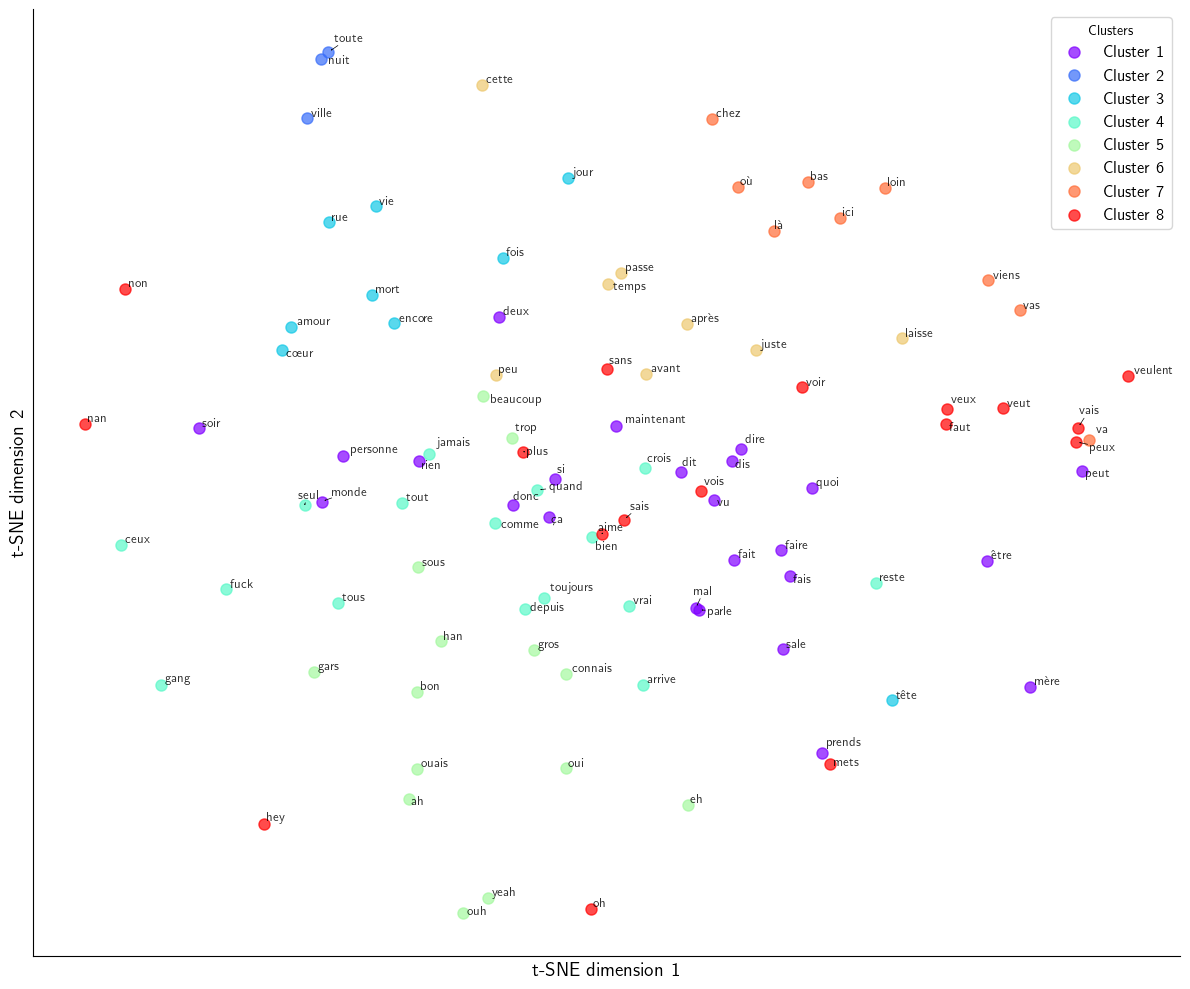

In [ ]:
# Run k-means clustering
n_clusters = 8

cluster_info = kmeans_cluster_embeddings(
    model_to_validate, 
    n_words=100,
    n_clusters=n_clusters,
    save_path=f'figs/k_means/kmeans_word_clusters_{n_clusters}.png'
)

### Intrinsic Evaluation 2- Semantic similarity

As a more formal way to validate the word embeddings created, I assess semantic similarity. The idea is to compare levels of similarity (using cosine distance) represented by my word embeddings to pairs of words generally considered as similar. Due to the lack of gold-standard dataset for this task in French, I used Claude Sonnet 3.7 and ChatGPT-o1 to translate Finkelstein et al. (2001)'s WordSim353 [1] [2]. Being a French native speaker, I was able to validate the translation and resolve conflicts myself. This dataset contains 353 word pairs, each associated with an average of 13 to 16 human judgements on their similarity. Importantly, both similarity and relatedness, which are two distinct concepts, are annotated without distinction. However, studies have found that human scores for both are very highly correlated with each other [3]. The trivial `tiger--tiger` pair was omitted, along with pairs where the translated words were the same. Finally, I also removed pairs whose association in English had no equivalent in French (e.g. 'soap' and 'opera').

----
[1]: Finkelstein, L., Gabrilovich, E., Matias, Y., Rivlin, E., Solan, Z., Wolfman, G., & Ruppin, E. (2001). Placing search in context: The concept revisited. Proceedings of the 10th International Conference on World Wide Web, 406–414. https://doi.org/10.1145/371920.372094

[2]: Available at https://www.kaggle.com/datasets/julianschelb/wordsim353-crowd/data

[3]: (Miller and Charles, 1991; Resnik, 1995) as cited in Agirre, E., Alfonseca, E., Hall, K., Kravalova, J., Paşca, M., & Soroa, A. (2009). A study on similarity and relatedness using distributional and WordNet-based approaches. Proceedings of Human Language Technologies: The 2009 Annual Conference of the North American Chapter of the Association for Computational Linguistics, 19–27.


Evaluating frRap_non_lemma_skipgram_100_5 on word similarity...
Number of word pairs not in vocabulary: 90 / 346 (26.01%)
Evaluation results:
Pearson correlation: 0.2019 (p-value: 0.0012)
Spearman correlation: 0.2013 (p-value: 0.0012)


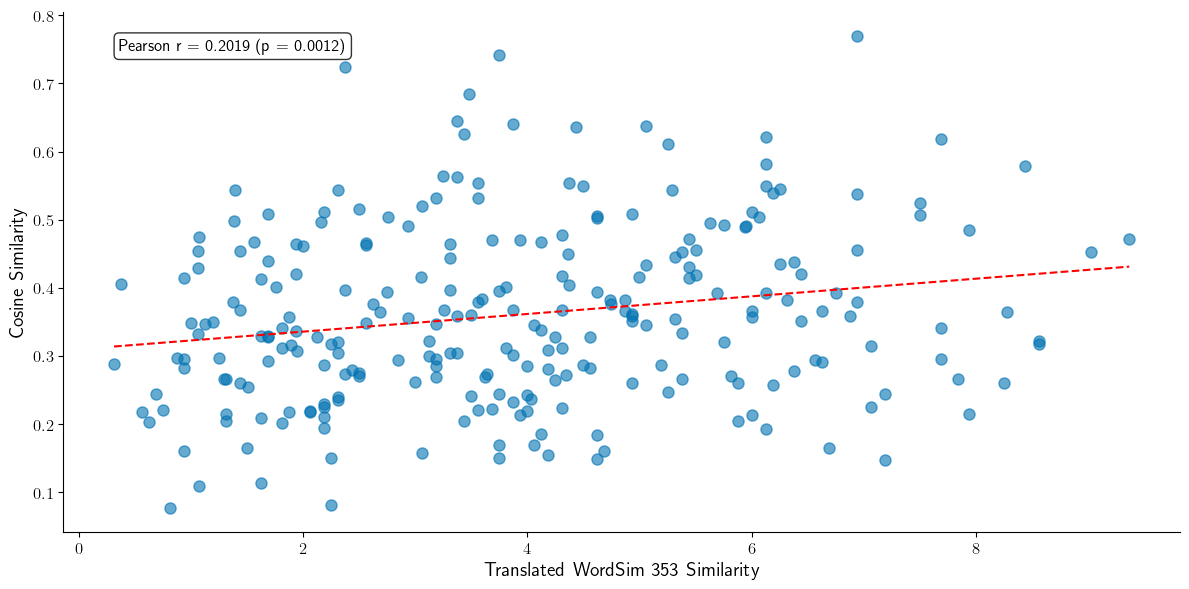

<Figure size 1000x600 with 0 Axes>

In [12]:
similarity_test_results_df = validate_models_similarity_task(models)

### Intrinsic validation 3 - Analogies

For the final part of the validation process, I partly follow Abdine et al. (2022)'s methodology of evaluating word embeddings [1]. Their first step is the **analogy task** [2]. In this task, we predict a word D by analyzing the semantic relationships between three input words A, B, and C. The prediction operates on the assumption that high-quality word embeddings preserve linear relationships between word pairs.

The process works as follows:

1. Given words A, B, and C, we access their vector representations (xA, xB, xC).
2. We compute a new vector using the formula: xB - xA + xC
3. We search the embedding dictionary for the word vector most similar to this result, which becomes our predicted word D.

For example, if we input "king," "man," and "woman," a good embedding system should predict "queen" because the relationship between "king" and "man" parallels the relationship between "queen" and "woman." Performance is measured by calculating the average accuracy across all test cases in the evaluation set. This approach effectively assesses how well word embeddings capture semantic relationships between concepts.

To evaluate my word embeddings, I utilised the French analogy dataset developed by Grave et al. (2018). This comprehensive dataset contains 31,688 analogy questions designed to test semantic and syntactic relationships [3]. I benchmarked my embeddings against three established French word vector models:

- French FastText (cc.fr.300) - also created by Grave et al. (2018)
- French Wacky word vectors
- Abdine et al. (2022)'s CBoW and Skip-Gram models trained on Large-Scale French Web Content

This comparative evaluation allows me to assess the relative performance of my embeddings against well-established baselines in capturing linguistic relationships within the French language context.

---------
[1]: Abdine, H., Xypolopoulos, C., Eddine, M. K., & Vazirgiannis, M. (2022). Evaluation Of Word Embeddings From Large-Scale French Web Content (No. arXiv:2105.01990). arXiv. https://doi.org/10.48550/arXiv.2105.01990

[2]: Mikolov, T., Chen, K., Corrado, G., & Dean, J. (2013). Efficient Estimation of Word Representations in Vector Space (No. arXiv:1301.3781). arXiv. https://doi.org/10.48550/arXiv.1301.3781

[3]: Grave, E., Bojanowski, P., Gupta, P., Joulin, A., & Mikolov, T. (2018). Learning Word Vectors for 157 Languages. In N. Calzolari, K. Choukri, C. Cieri, T. Declerck, S. Goggi, K. Hasida, H. Isahara, B. Maegaard, J. Mariani, H. Mazo, A. Moreno, J. Odijk, S. Piperidis, & T. Tokunaga (Eds.), Proceedings of the Eleventh International Conference on Language Resources and Evaluation (LREC 2018). European Language Resources Association (ELRA). https://aclanthology.org/L18-1550/


In [13]:
# Word analogy task from Grave et al., 2018
# Source: https://fasttext.cc/docs/en/crawl-vectors.html

# Evaluate the full model and save correct analogies
analogies_test_results_df = validate_models_analogy_task(
    models, 
    save_correct=True,
    )

Parsed 14 categories with a total of 31562 questions

Evaluating model: frRap_non_lemma_skipgram_100_5
Saved correct analogies to results/correct_analogies/correct_analogies_frRap_non_lemma_skipgram_100_5.md
  Accuracy: 0.0265, Skipped: 27672


In [16]:
# Print sorted analogy categories for the first model
print_sorted_categories(analogies_test_results_df, model_to_validate.name)


Category Performance for model 'frRap_non_lemma_skipgram_100_5' (best to worst):
  family: 0.0625
  gram7-past-tense: 0.0471
  gram4-past-participle: 0.0455
  gram8-plural-verbs: 0.0179
  gram2-opposite: 0.0110
  gram5-plural: 0.0092
  antonyms-adjectives: 0.0073
  gram3-present-participle: 0.0042
  gram1-adjective-to-adverb: 0.0000


**!! Limitation of the study: No extrinsic evaluation !!**

Extrinsic evaluation, which consists of testing the word embeddings on external tasks such as NER or parts-of-speech tagging, would allow to evaluate the actual usefulness of the embeddings.

## Gender Stereotypes Analysis

### Word Embedding Association Test 
A popular method of testing for the presence of gender bias in word embeddings is the Word Embedding Association Test (WEAT), created by Caliskan et al. (2017) [1] and subsequently improved on by Garg et al. (2018) [2] Chaloner & Maldonado (2019) [3] and Betti et al. (2023)[4]. 

1. **Define word sets**
- Two target word sets (X, Y) representing concept categories. I gather them from Caliskan et al. (2017), Garg et al. (2018), Chaloner & Maldonado (2019), and Betti et al. (2023).
    - *Career vs. Family*
    - *Maths / Science vs. Arts* 
    - Differences on *personal descriptions in terms of intelligence vs. appearance*
    - Physical or emotional *strength vs. weakness*

- Two attribute word sets (M, F) representing male and female concepts

The null hypothesis (H0) is that there is no difference between $M$ and $F$ in terms of their relative cosine similarity to $X$ and $Y$.

2. **Calculate association measure for each target word, and test statistic**

I first calculate the **measure of association** between target word $w$, and the attribute words in $M$ and $F$. 

\begin{equation}
s(w, M, F) = \frac{1}{|M|} \sum_{m\in M} \cos(\vec{w}, \vec{m}) - \frac{1}{|F|} \sum_{f\in F} \cos(\vec{w}, \vec{f})
\end{equation}

Then, I compute the following **test statistic**

\begin{equation}
s(X, Y, M, F) = \sum_{x\in X} s(x, M, F) - \sum_{y\in Y} s(y, M, F).
\end{equation}

H0 is tested in Caliskan et al. (2017) through a permutation test, where all words in $X$ and $Y$ are partitioned in alternative target lists $\hat{X}$ and $\hat{Y}$ exhaustively, and the one-sided p-value $p[s(\hat{X}, \hat{Y}, M, F) > s(X, Y, M, F)]$ is computed. This value represents the proportion of partition permutations in which the test statistic $s(\hat{X}, \hat{Y}, M, F)$ is greater tham the observed test statistic $s(X, Y, M, F)$, i.e., the probability that H0 is true, and that there is no difference between $X$ and $Y$ in relation to $M$ and $F$.

Similarly to Betti et al. (2023), I use randomisation tests with a maximimum of 1,000 iterations instead of the exhaustive permutation tests.

3. **Calculate effect size using Cohen's d**

\begin{equation}
d = \frac{\text{mean}_{x \in X} s(x, M, F) - \text{mean}_{y \in Y} s(y, M, F)}{SD_{\textbf{pooled}_{w \in X \cup Y}} s(w, M, F)}
\end{equation}

where $SD_{\textbf{pooled}}$ is calculated as:

\begin{equation}
\text{SD}_{\text{pooled}} = \sqrt{\frac{(\text{SD}_X^2 + \text{SD}_Y^2)}{2}}
\end{equation}

where $\text{SD}_X$ is the standard deviation of the association measures $s(x, M, F)$ for all $x \in X$, and $\text{SD}_Y$ is the standard deviation of the association measures $s(y, M, F)$ for all $y \in Y$.

Based on this formulation, a positive effect size would indicate that the words in $X$ are more similar to the words in $M$ than in $F$, and the words in $Y$ are more similar to the words in $F$ than in $M$.

-----
[1] Caliskan, A., Bryson, J. J., & Narayanan, A. (2017). Semantics derived automatically from language corpora contain human-like biases. Science, 356(6334), 183–186. https://doi.org/10.1126/science.aal4230

[2] Garg, N., Schiebinger, L., Jurafsky, D., & Zou, J. (2018). Word embeddings quantify 100 years of gender and ethnic stereotypes. Proceedings of the National Academy of Sciences, 115(16), E3635–E3644. https://doi.org/10.1073/pnas.1720347115

[3] Chaloner, K., & Maldonado, A. (2019). Measuring Gender Bias in Word Embeddings across Domains and Discovering New Gender Bias Word Categories. In M. R. Costa-jussà, C. Hardmeier, W. Radford, & K. Webster (Eds.), Proceedings of the First Workshop on Gender Bias in Natural Language Processing (pp. 25–32). Association for Computational Linguistics. https://doi.org/10.18653/v1/W19-3804

[4] Betti, L., Abrate, C., & Kaltenbrunner, A. (2023). Large scale analysis of gender bias and sexism in song lyrics. EPJ Data Science, 12(1), Article 1. https://doi.org/10.1140/epjds/s13688-023-00384-8


In [3]:
# Load model
model = Word2Vec.load("models/frRap_non_lemma_skipgram_100_5/model")
model_name = "frRap_non_lemma_skipgram_100_5"

# Initialize the WEAT analyser (from utils.analysis_helpers)
WEAT_analyser = GenderBiasWEATAnalyser(model)

In [4]:
# Run the WEAT analysis for all gender bias categories
WEAT_results = WEAT_analyser.analyse_all_categories(n_permutations=1000)

Analysing category: B1_career_family
  P-value: 0.1540, Effect size: 0.5723
  X words in vocab: 10/10
  Y words in vocab: 6/7
  Interpretation: Category X words are more associated with male attributes (Effect size 0.572320072589603, not statistically significant, p=0.1540)
Analysing category: B2_mathsci_arts
  P-value: 0.0900, Effect size: 0.7590
  X words in vocab: 7/7
  Y words in vocab: 6/6
  Interpretation: Category X words are more associated with male attributes (Effect size 0.7590054563503212, not statistically significant, p=0.0900)
Analysing category: B3_intel_appearance
  P-value: 0.0150, Effect size: 1.0394
  X words in vocab: 9/9
  Y words in vocab: 12/12
  Interpretation: Category X words are more associated with male attributes (Effect size 1.0393950813096804, statistically significant, p=0.0150)
Analysing category: B4_strength_weakness
  P-value: 0.7280, Effect size: -0.3570
  X words in vocab: 6/9
  Y words in vocab: 9/10
  Interpretation: Category Y words are more ass

## Comparing to off-the-shelf French word embeddings

### fastText

Source: https://fasttext.cc/docs/en/crawl-vectors.html

"We distribute pre-trained word vectors for 157 languages, trained on Common Crawl and Wikipedia using fastText. These models were trained using CBOW with position-weights, in dimension 300, with character n-grams of length 5, a window of size 5 and 10 negatives. We also distribute three new word analogy datasets, for French, Hindi and Polish."

### Word2Vec (2015)

Source: https://fauconnier.github.io/#data

1. frWac2Vec
    - Trained on the FrWac corpus (1.6 billion words)
    - Available in a CBOW & skip-gram, dimensions (200, 500, 700, 1000), and cutoffs (0, 10, 50, 100, 200)

2. frWiki2Vec
    - Trained on the FrWiki dump (600 millions words)
    - Available in a CBOW & skip-gram, dimensions (500, 700, 1000), and cutoffs (10, 100, 200)